In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import load_iris

from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Загружаем данные
data = load_iris(as_frame=True)
df = data.frame

# Выбираем базовые признаки для первых этапов
features_base = ['sepal length (cm)', 'petal length (cm)']
X_base = df[features_base]

print("Первые 10 строк данных (базовые признаки):")
print(X_base.head(10))
print("\nОписание базовых признаков:")
print(X_base.describe())

Первые 10 строк данных (базовые признаки):
   sepal length (cm)  petal length (cm)
0                5.1                1.4
1                4.9                1.4
2                4.7                1.3
3                4.6                1.5
4                5.0                1.4
5                5.4                1.7
6                4.6                1.4
7                5.0                1.5
8                4.4                1.4
9                4.9                1.5

Описание базовых признаков:
       sepal length (cm)  petal length (cm)
count         150.000000         150.000000
mean            5.843333           3.758000
std             0.828066           1.765298
min             4.300000           1.000000
25%             5.100000           1.600000
50%             5.800000           4.350000
75%             6.400000           5.100000
max             7.900000           6.900000


##2. Диаграмма рассеивания. Первое предположение К1.

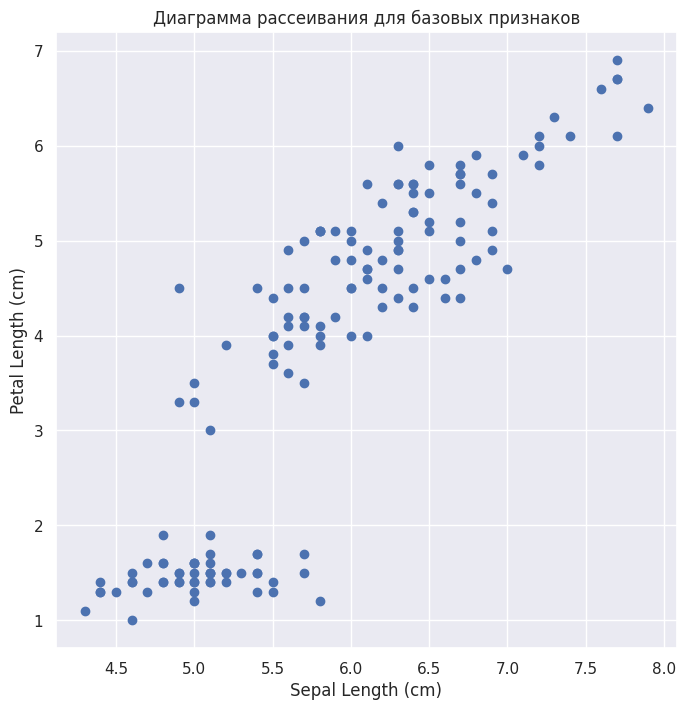

In [50]:
plt.figure(figsize=(8,8))
plt.scatter(X_base['sepal length (cm)'], X_base['petal length (cm)'])
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.title('Диаграмма рассеивания для базовых признаков')
plt.grid(True)
plt.show()

Исходя из графика можно выделить 3 кластера: нижний левый, центральный и верхний правый.

##3.Метод локтя. К2.

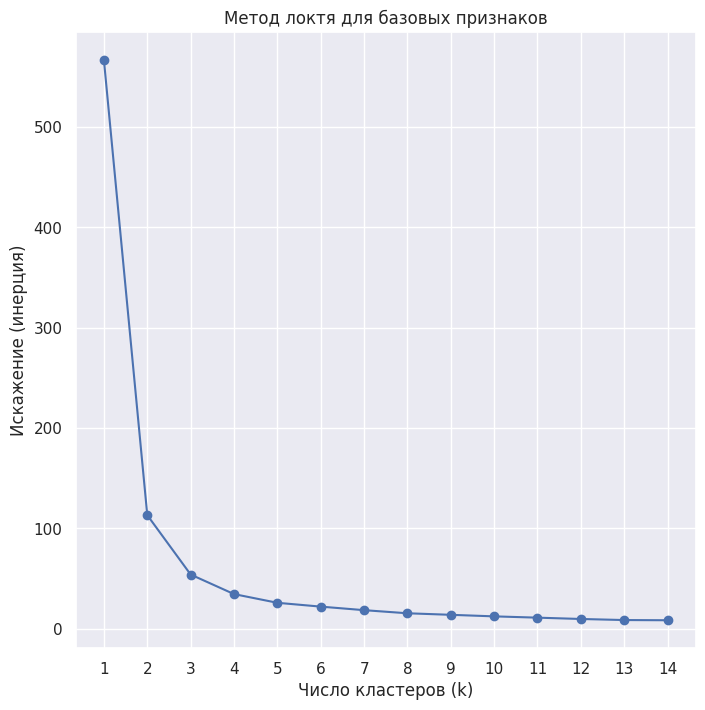

In [51]:
distortions = []
K_range = range(1, 15)

for k in K_range:
    km = KMeans(n_clusters=k, init='random', n_init=15, max_iter=150, random_state=26)
    km.fit(X_base)
    distortions.append(km.inertia_)

plt.figure(figsize=(8,8))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Искажение (инерция)')
plt.title('Метод локтя для базовых признаков')
plt.xticks(K_range)
plt.grid(True)
plt.show()

На графике резкий излом (локоть) происходит при k=2.


##4.Кластеризация К-средними К1 и К2, рассчёт силуэтных коэффициентов.

In [52]:
# --- Кластеризация для k1 ---
kmeans_3 = KMeans(n_clusters=3, init='random', n_init=15, max_iter=150, random_state=26)
labels_3 = kmeans_3.fit_predict(X_base)
silhouette_avg_3 = silhouette_score(X_base, labels_3)
print(f"Средний силуэтный коэффициент для k=3: {silhouette_avg_3:.4f}")

# --- Кластеризация для k2 ---
kmeans_2 = KMeans(n_clusters=2, init='random', n_init=15, max_iter=150, random_state=26)
labels_2 = kmeans_2.fit_predict(X_base)
silhouette_avg_2 = silhouette_score(X_base, labels_2)
print(f"Средний силуэтный коэффициент для k=2: {silhouette_avg_2:.4f}")

# --- Вывод лучшего варианта ---
best_k = 3 if silhouette_avg_3 > silhouette_avg_2 else 2
print(f"\nЛучшее разбиение по среднему силуэту: k = {best_k}")

Средний силуэтный коэффициент для k=3: 0.5891
Средний силуэтный коэффициент для k=2: 0.7098

Лучшее разбиение по среднему силуэту: k = 2


Средний силуэтный коэффициент для k=2 (0.7098) выше, чем для k=3 (0.5891). Разбиение на 2 кластера более качественное и структурированное.

##5. Диаграмма рассеивания с центроидами.

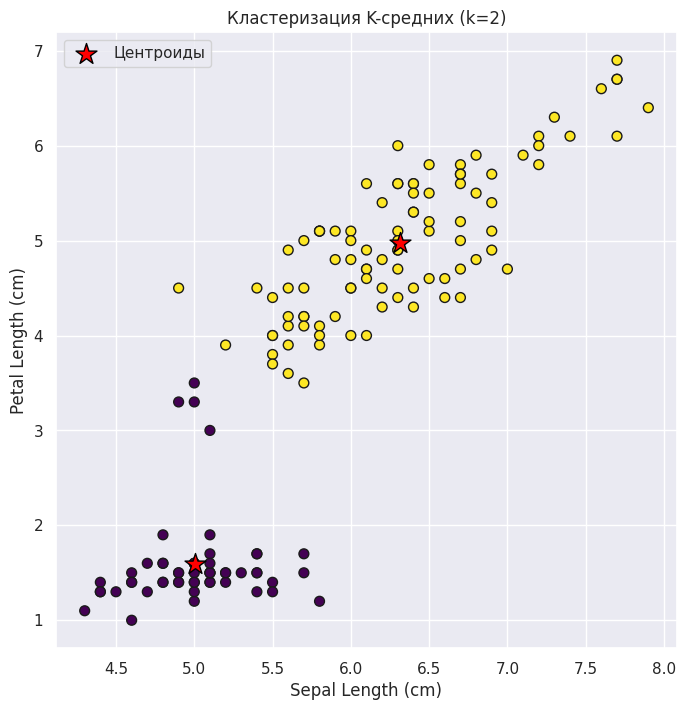

In [53]:
# Используем модель с k=2, полученную на предыдущем шаге
centroids = kmeans_2.cluster_centers_

plt.figure(figsize=(8,8))
plt.scatter(X_base['sepal length (cm)'], X_base['petal length (cm)'],
            c=labels_2, cmap='viridis', s=50, alpha=1, edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1],
            s=250, marker='*', c='red', label='Центроиды', edgecolors='black')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.title('Кластеризация K-средних (k=2)')
plt.legend()
plt.grid(True)
plt.show()

##6.Добавление дополнительного показателя. Разделение выборки на обучающую и прогнозную 80%-20%.

In [54]:
# Добавляем третий признак
features_all = ['sepal length (cm)', 'petal length (cm)', 'sepal width (cm)']
X_all = df[features_all]

# Разделение на обучающую и прогнозную выборки
df_train = X_all.sample(frac=0.8, random_state=26)
df_predict = X_all.drop(df_train.index)

print(f"Размер обучающей выборки: {len(df_train)}")
print(f"Размер прогнозной выборки: {len(df_predict)}")

Размер обучающей выборки: 120
Размер прогнозной выборки: 30


##7.Метод локтя с тремя признаками.

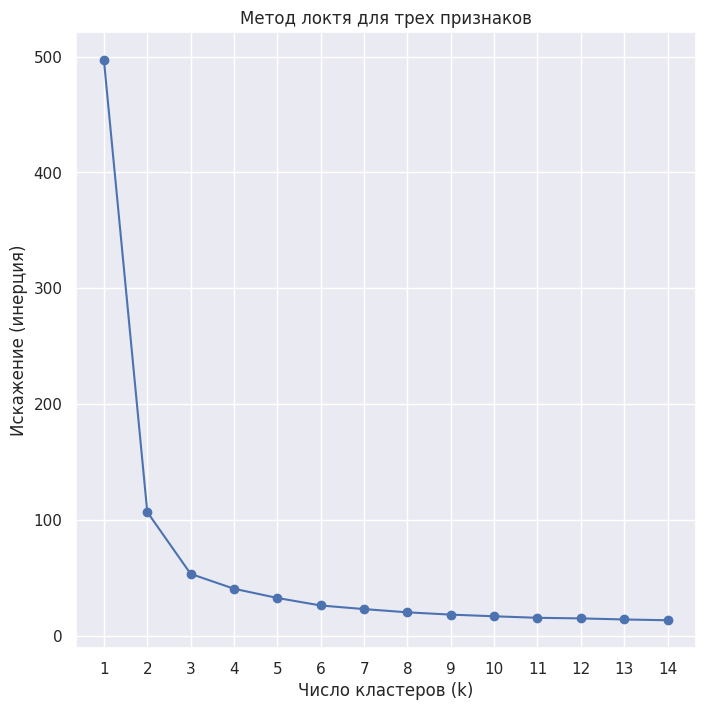

In [55]:
distortions_all = []

for k in K_range:
    km = KMeans(n_clusters=k, init='random', n_init=15, max_iter=100, random_state=26)
    km.fit(df_train) # Обучаемся только на обучающей выборке
    distortions_all.append(km.inertia_)

plt.figure(figsize=(8,8))
plt.plot(K_range, distortions_all, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Искажение (инерция)')
plt.title('Метод локтя для трех признаков')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Локоть, при добавлении 3-го признака,  по прежнему остается при к=2.

##8. Кластеризация на обучающей выборке. Визуальный анализ стат.распределения в кластерах.

<Figure size 800x800 with 0 Axes>

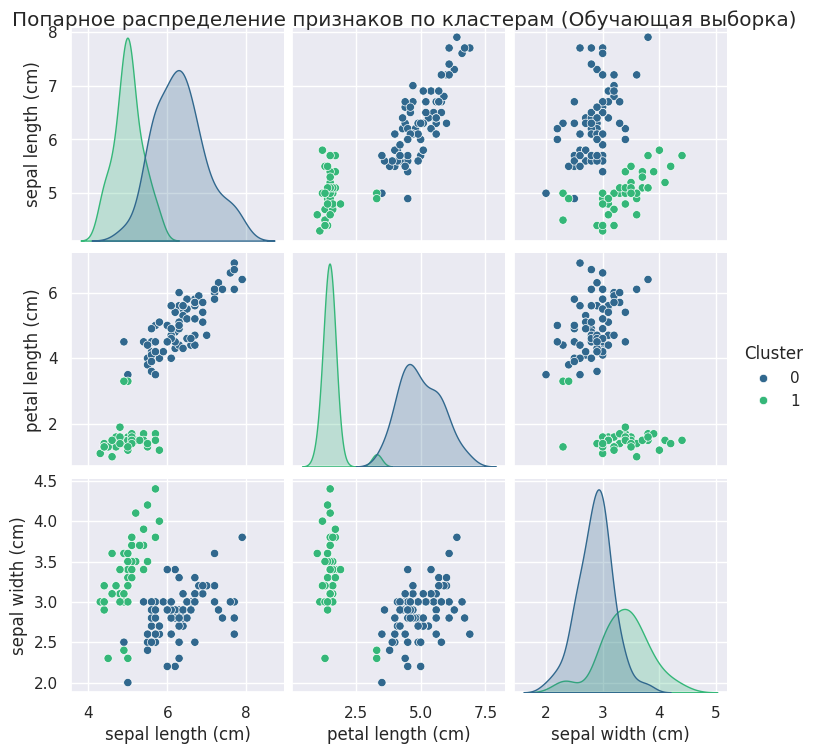

In [57]:
# Кластеризация на обучающей выборке
kmeans_final = KMeans(n_clusters=2, init='random', n_init=15, max_iter=100, random_state=26)
train_labels = kmeans_final.fit_predict(df_train)

# Добавляем метки кластеров в обучающий фрейм для визуализации
df_train_clustered = df_train.copy()
df_train_clustered['Cluster'] = train_labels

# Визуальный анализ с помощью pairplot
plt.figure(figsize=(8,8))
sns.pairplot(df_train_clustered, hue='Cluster', diag_kind='kde', palette='viridis')
plt.suptitle('Попарное распределение признаков по кластерам (Обучающая выборка)', y=1)
plt.show()

На графике petal_length к sepal_length кластеры практически идеально разделяются, как на диаграмме рассеивания. <br> Примерно схожи по качеству разделения графики petal_length к sepal_width и sepal_length к sepal_width. <br> На гистограммах petal_length показывает наилучшее разделение.


## 9. Прогноз для прогнозной выборки.

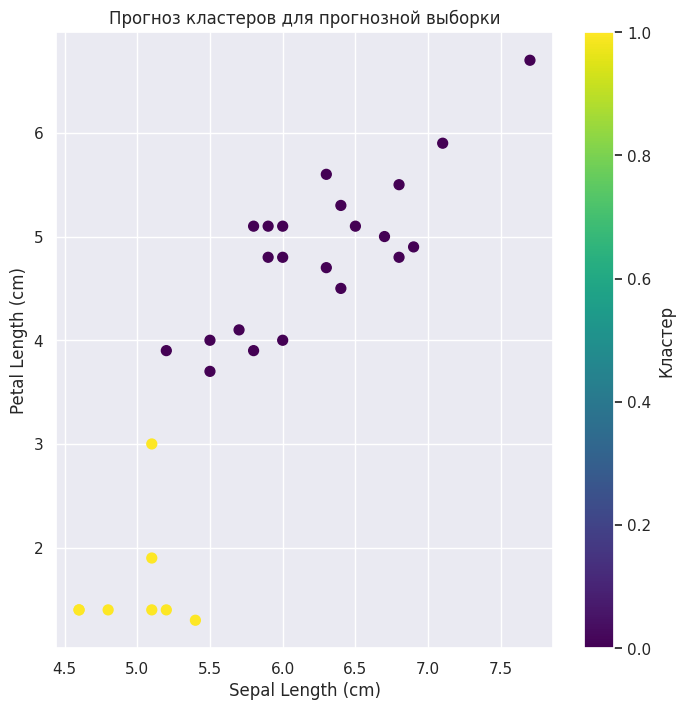

In [59]:
# Предсказание для прогнозной выборки
predict_labels = kmeans_final.predict(df_predict)

# Добавляем метки в фрейм для визуализации
df_predict_clustered = df_predict.copy()
df_predict_clustered['Cluster'] = predict_labels

# Визуализация прогнозов
plt.figure(figsize=(8,8))
scatter = plt.scatter(df_predict_clustered['sepal length (cm)'],
                      df_predict_clustered['petal length (cm)'],
                      c=df_predict_clustered['Cluster'], cmap='viridis', s=50, alpha=1)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.title('Прогноз кластеров для прогнозной выборки')
plt.colorbar(scatter, label='Кластер')
plt.grid(True)
plt.show()

Распределение на прогнозной выборке показало идентичные результаты с обучающей.

##Доп.задание. Оценка точности.

In [60]:
from sklearn.metrics import adjusted_rand_score

# Истинные метки для всей выборки
true_labels_all = data.target

# Предсказания для всей выборки (используем финальную модель)
labels_all = kmeans_final.fit_predict(X_all)

# Расчет ARI
ari_score = adjusted_rand_score(true_labels_all, labels_all)
print(f"Скорректированный индекс Рэнда (ARI): {ari_score:.4f}")

Скорректированный индекс Рэнда (ARI): 0.5399


Индекс ARI=0,5399 показывает неплохое согласование между кластерами к видам ирисов.